In [1]:
source = "https://raw.githubusercontent.com/dartfather/ml/main/nhanes_2005_2005_for_students_1.csv"

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(source, index_col=0)
print(df.head(5))

categorical_columns = ['VIG_ACT', 'MOD_ACT', "MEAN_ACT", "diabetes", "high_b_pressure", "gender", "cancer", "deppresed"]
continuous_columns = ["SEQN", "ALC_12m", "weight", "height", "bmi", "waist", "age", "pulse", "sys_pressure"]
target_column = 'subjective_health'

X = df[categorical_columns + continuous_columns]
y = df[target_column]

# changing classes 4 and 5 to just 4
y[y == 5] = 4
df.describe()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# this makes sure that dataset is balanced. Otherwise class 1 had 230 data points, while class 3 had 810
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
x_full_resampled, y_full_resampled = smote.fit_resample(X, y)

      SEQN  ALC_12m  MEAN_ACT  VIG_ACT  MOD_ACT  weight  height    bmi  waist  \
0  31132.0      208         2        2        1    69.5   167.6  24.74   96.5   
1  31134.0      104         3        2        1   101.9   182.4  30.63  117.1   
2  31144.0       24         2        1        1    69.9   167.1  25.03   84.6   
3  31150.0      364         4        1        1    85.0   171.4  28.93  107.7   
5  31158.0      208         3        2        1    69.2   178.8  21.65   85.5   

   diabetes  high_b_pressure  gender   age  pulse  sys_pressure  \
0       1.0              1.0     1.0  70.0   62.0         138.0   
1       2.0              1.0     1.0  73.0   50.0         130.0   
2       2.0              2.0     1.0  21.0   54.0         116.0   
3       2.0              2.0     1.0  79.0   66.0         144.0   
5       2.0              1.0     1.0  71.0   54.0         154.0   

   subjective_health  cancer  deppresed  
0                2.0     2.0        0.0  
1                3.0     2

<ipython-input-2-66dfebc09052>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 5] = 4


Original Class Distribution (Counts):
subjective_health
3.0    810
2.0    688
4.0    346
1.0    230
Name: count, dtype: int64

Original Class Distribution (Percentage):
subjective_health
3.0    39.054966
2.0    33.172613
4.0    16.682739
1.0    11.089682
Name: proportion, dtype: float64


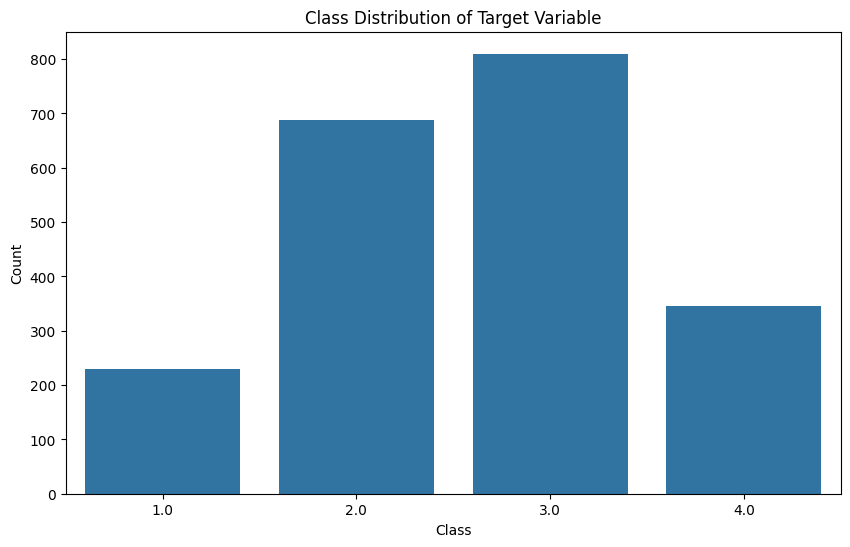

In [3]:
class_distribution = y.value_counts()
class_distribution_percentage = y.value_counts(normalize=True) * 100

print("Original Class Distribution (Counts):")
print(class_distribution)
print("\nOriginal Class Distribution (Percentage):")
print(class_distribution_percentage)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution of Target Variable')
plt.show()

Resampled Class Distribution (Counts):
subjective_health
2.0    810
3.0    810
1.0    810
4.0    810
Name: count, dtype: int64
\Resampled Class Distribution (Percentage):
subjective_health
2.0    25.0
3.0    25.0
1.0    25.0
4.0    25.0
Name: proportion, dtype: float64


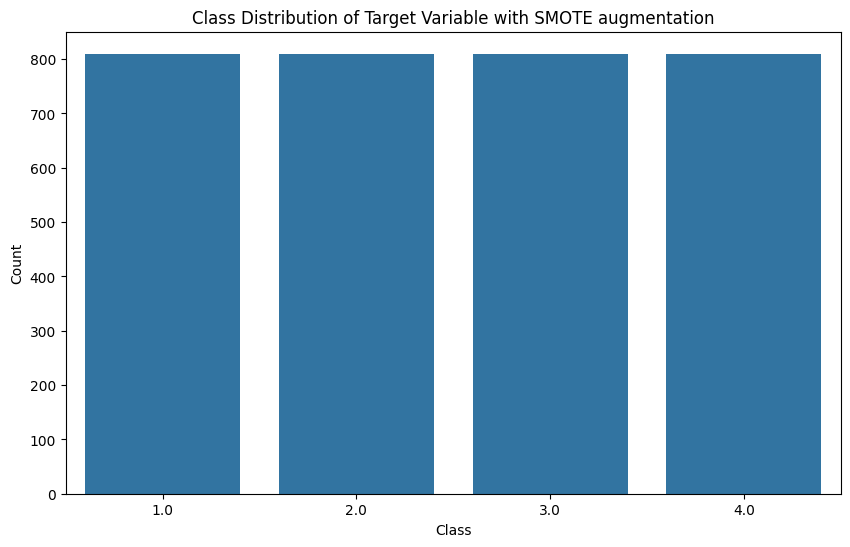

In [4]:
class_distribution = y_full_resampled.value_counts()
class_distribution_percentage = y_full_resampled.value_counts(normalize=True) * 100

print("Resampled Class Distribution (Counts):")
print(class_distribution)
print("\Resampled Class Distribution (Percentage):")
print(class_distribution_percentage)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution of Target Variable with SMOTE augmentation')
plt.show()

In [5]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

DTCModel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [6]:
DTCModel.fit(X_train, y_train)
y_pred = DTCModel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.45542168674698796


In [7]:
# Calculate feature importances
classifier = DTCModel.named_steps['classifier']
preprocessor = DTCModel.named_steps['preprocessor']
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
feature_names = np.concatenate([continuous_columns, onehot_columns])
importances = classifier.feature_importances_

# Display feature importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

                feature  importance
4                   bmi    0.097157
0                  SEQN    0.093026
3                height    0.092700
5                 waist    0.091132
2                weight    0.087331
6                   age    0.083853
8          sys_pressure    0.082337
7                 pulse    0.079168
1               ALC_12m    0.070256
16           MEAN_ACT_2    0.017449
29        deppresed_0.0    0.017140
15           MEAN_ACT_1    0.014672
17           MEAN_ACT_3    0.014659
9             VIG_ACT_1    0.013628
26           gender_2.0    0.013413
12            MOD_ACT_1    0.012721
23  high_b_pressure_1.0    0.012596
25           gender_1.0    0.012250
10            VIG_ACT_2    0.011952
24  high_b_pressure_2.0    0.011426
13            MOD_ACT_2    0.011112
18           MEAN_ACT_4    0.010390
30        deppresed_1.0    0.009280
20         diabetes_1.0    0.007177
21         diabetes_2.0    0.007003
28           cancer_2.0    0.006429
27           cancer_1.0    0

In [8]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continuous_columns),
        ('cat', categorical_transformer, categorical_columns)])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, C=200),
    "GradientBoostingClassifier": GradientBoostingClassifier(learning_rate=0.02, n_estimators=30),
    "SVC": SVC(kernel='linear'),
    "SVC_rbf": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier()
}

results = {}

scoring = {
    "precision":make_scorer(precision_score, average='weighted', zero_division=0),
    "recall":make_scorer(recall_score, average='weighted', zero_division=0),
    "f1":make_scorer(f1_score, average='weighted', zero_division=0),
    "accuracy":make_scorer(accuracy_score)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    cv = StratifiedKFold(n_splits=5)
    for metric in scoring:
        cv_results = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring[metric])
        results[f"{name}_{metric}"] = cv_results
        print(f"{name}_{metric}: {np.mean(cv_results)}")

results_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in results.items()]))

LogisticRegression_precision: 0.4011023168665444
LogisticRegression_recall: 0.4291333449740993
LogisticRegression_f1: 0.3972020548989705
LogisticRegression_accuracy: 0.4291333449740993
GradientBoostingClassifier_precision: 0.4185922041623377
GradientBoostingClassifier_recall: 0.409335894301845
GradientBoostingClassifier_f1: 0.31092702839403163
GradientBoostingClassifier_accuracy: 0.409335894301845
SVC_precision: 0.4096327617626724
SVC_recall: 0.43394912985274436
SVC_f1: 0.385866898387963
SVC_accuracy: 0.43394912985274436
SVC_rbf_precision: 0.43615900521881495
SVC_rbf_recall: 0.43104708689831794
SVC_rbf_f1: 0.3666665161777717
SVC_rbf_accuracy: 0.43104708689831794
DTC_precision: 0.3612303055113092
DTC_recall: 0.3278912752459112
DTC_f1: 0.3497734525449582
DTC_accuracy: 0.33077818520458646


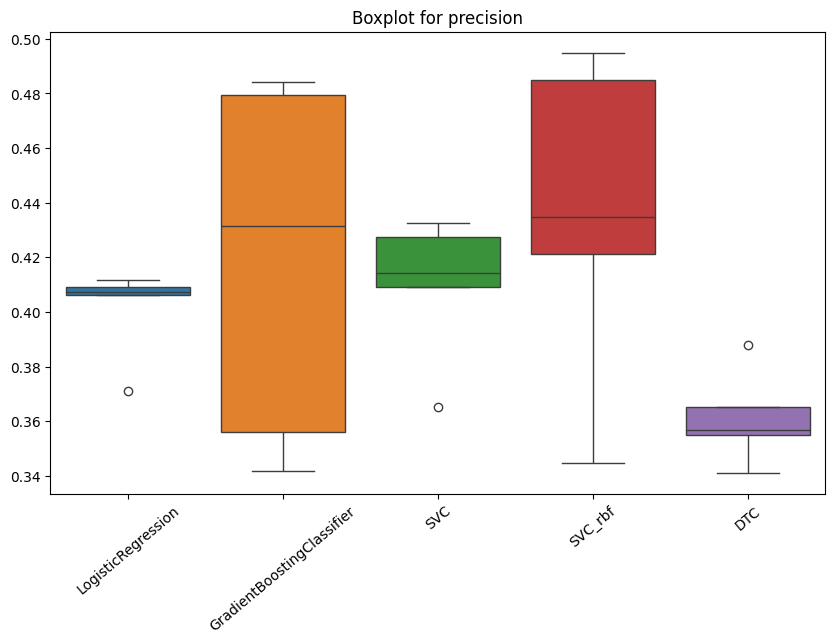

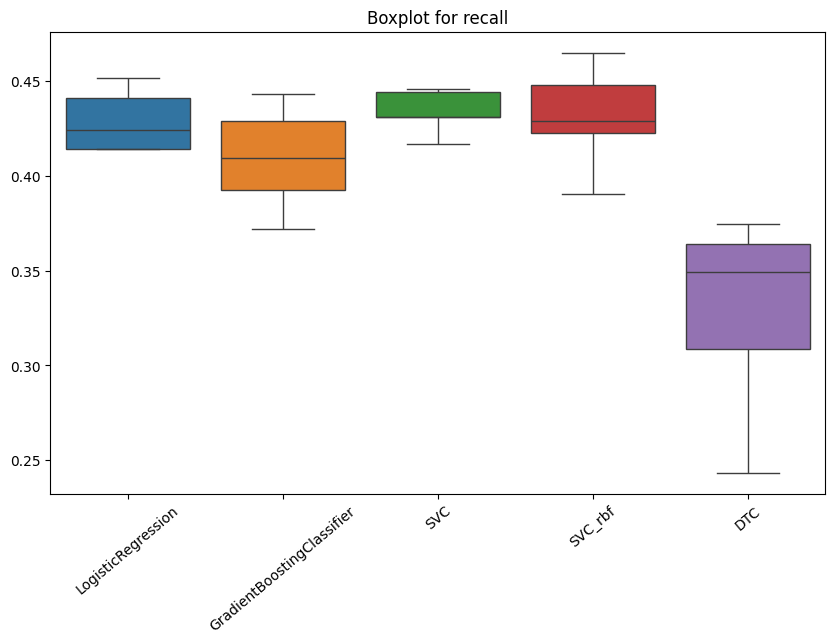

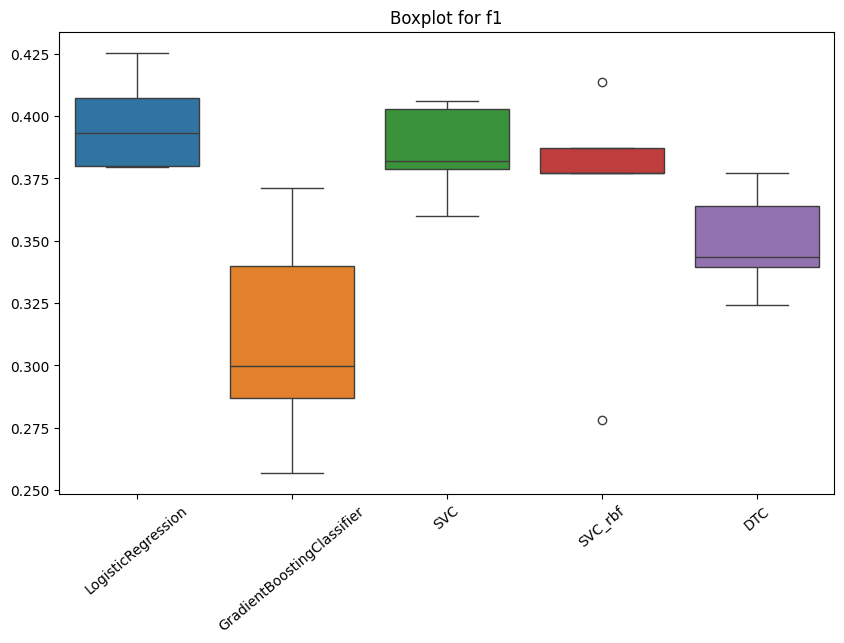

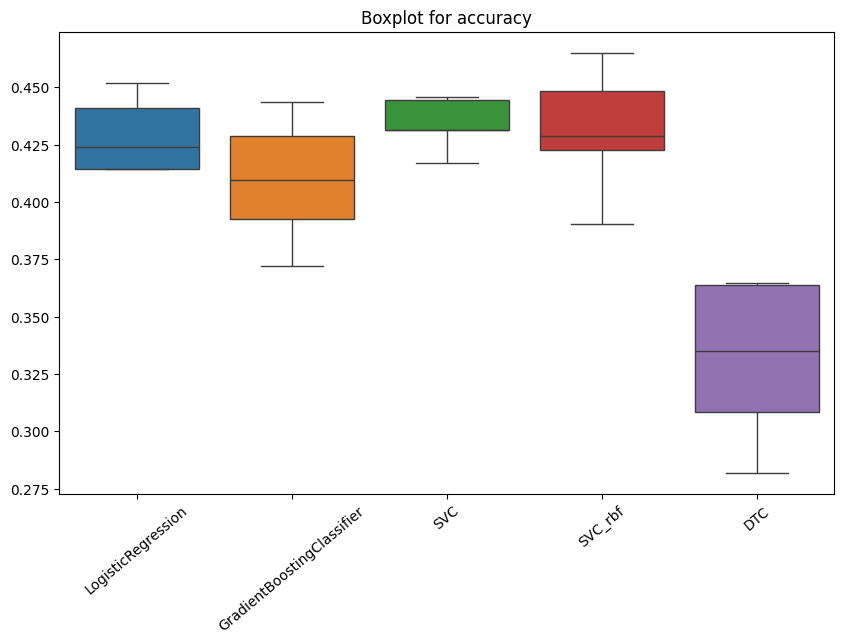

In [9]:
for metric in scoring:
    metric_df = results_df.filter(like=metric, axis=1)
    metric_df.columns = [col.replace(f'_{metric}', '') for col in metric_df.columns]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metric_df)
    plt.title(f'Boxplot for {metric}')
    plt.xticks(rotation=40)
    plt.show()

In [10]:
test_results = {}

for name, model in models.items():
	pipeline = Pipeline(steps=[('preprocessor', preprocessor),
							   ('classifier', model)])
	pipeline.fit(X, y)

	y_pred = pipeline.predict(X_test)

	accuracy = accuracy_score(y_test, y_pred)
	f1 = f1_score(y_test, y_pred, average='macro')

	test_results[f"{name}_accuracy"] = accuracy
	test_results[f"{name}_f1"] = f1

	print(f"{name} - Test Accuracy: {accuracy}, Test F1 Score: {f1}")

LogisticRegression - Test Accuracy: 0.5012048192771085, Test F1 Score: 0.37151346107203487
GradientBoostingClassifier - Test Accuracy: 0.4867469879518072, Test F1 Score: 0.2898268367151346
SVC - Test Accuracy: 0.5084337349397591, Test F1 Score: 0.3647921649359693
SVC_rbf - Test Accuracy: 0.5951807228915663, Test F1 Score: 0.41717910515147405
DTC - Test Accuracy: 1.0, Test F1 Score: 1.0


---

Here we use the same models but with SMOTE preprocessing. Dataset is not balanced, class 1 has 230 data points while class 3 has 810 data points. To make the model learn better, we used SMOTE preprocessing, which generates new data points to have the same amount of classes. We only used SMOTE on training dataset, leaving test dataset completely unchanged and free fromaugmentation. Additionally, it has been split into train/test efore SMOTE so we don't risk any test data points getting into the training dataset.

In [11]:
results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    cv = StratifiedKFold(n_splits=5)
    for metric in scoring:
        cv_results = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring[metric])
        results[f"{name}_{metric}"] = cv_results
        print(f"{name}_{metric}: {np.mean(cv_results)}")

results_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in results.items()]))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression_precision: 0.5033806780542038


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression_recall: 0.48480334599593267


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression_f1: 0.47156511490250563


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression_accuracy: 0.48480334599593267
GradientBoostingClassifier_precision: 0.47100966287319884
GradientBoostingClassifier_recall: 0.46440504969110935
GradientBoostingClassifier_f1: 0.4516478756961453
GradientBoostingClassifier_accuracy: 0.46440504969110935
SVC_precision: 0.528743977793934
SVC_recall: 0.49695944131077086
SVC_f1: 0.48101410915341136
SVC_accuracy: 0.49695944131077086
SVC_rbf_precision: 0.5400659280670232
SVC_rbf_recall: 0.5224189401788113
SVC_rbf_f1: 0.5107465486064499
SVC_rbf_accuracy: 0.5224189401788113
DTC_precision: 0.4830267495924292
DTC_recall: 0.4804850159241779
DTC_f1: 0.48079655571837776
DTC_accuracy: 0.4883151068646637


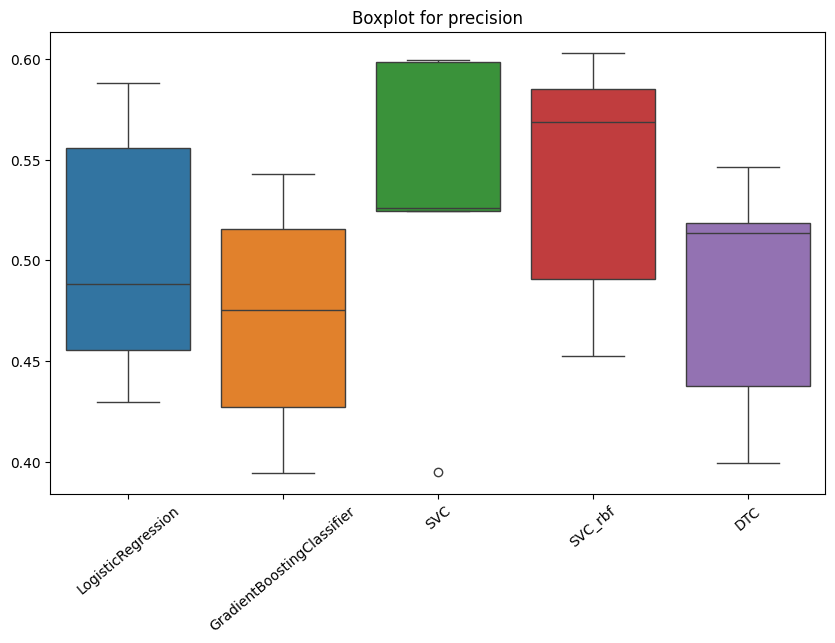

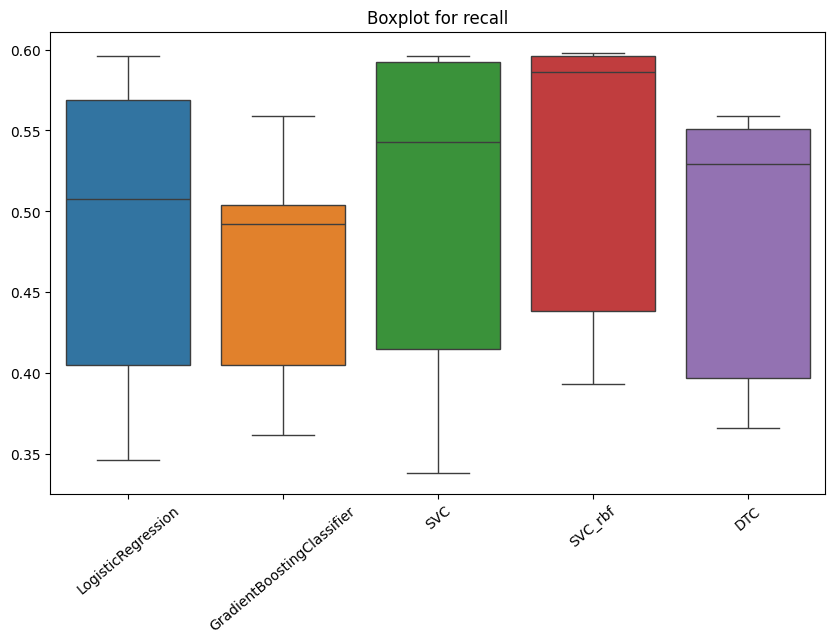

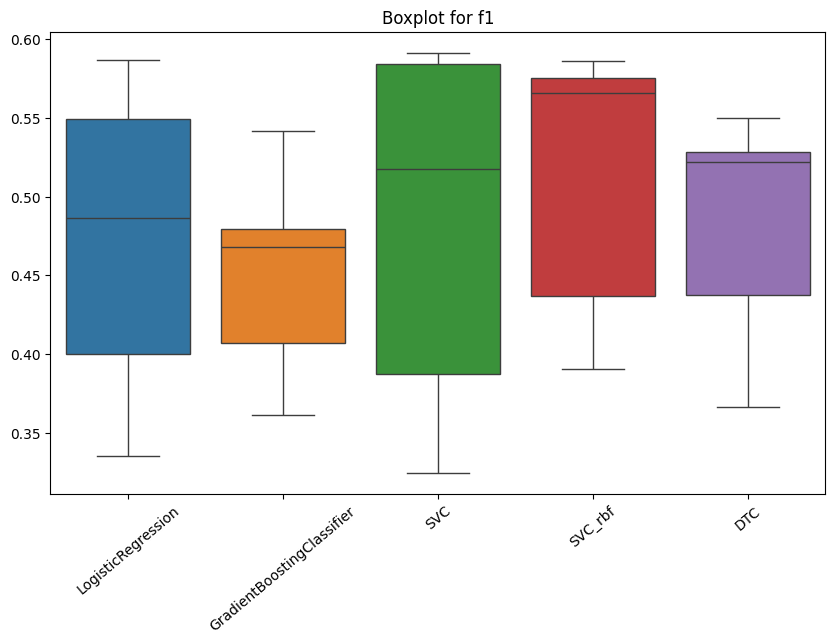

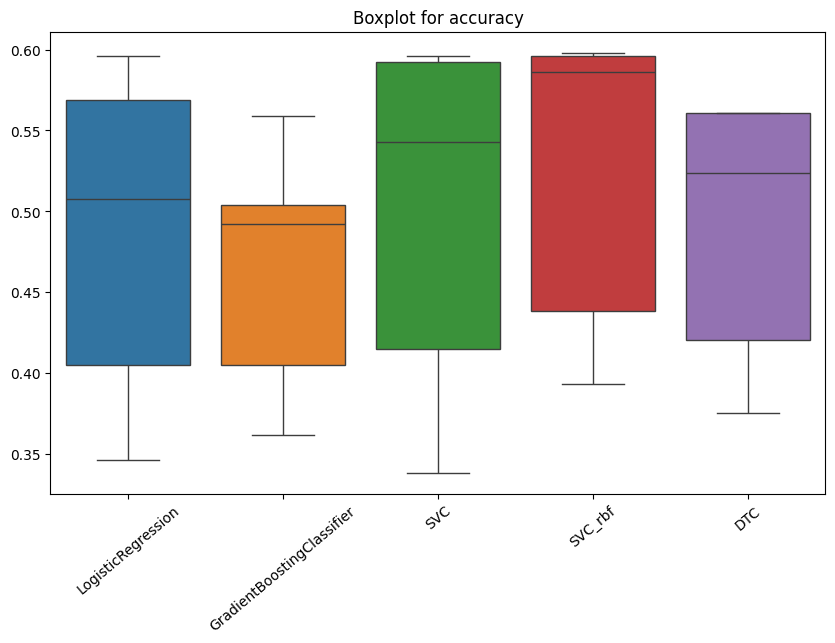

In [12]:
for metric in scoring:
    metric_df = results_df.filter(like=metric, axis=1)
    metric_df.columns = [col.replace(f'_{metric}', '') for col in metric_df.columns]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metric_df)
    plt.title(f'Boxplot for {metric}')
    plt.xticks(rotation=40)
    plt.show()

In [13]:
test_results = {}

for name, model in models.items():
	pipeline = Pipeline(steps=[('preprocessor', preprocessor),
							   ('classifier', model)])
	pipeline.fit(X, y)

	y_pred = pipeline.predict(X_test)

	accuracy = accuracy_score(y_test, y_pred)
	f1 = f1_score(y_test, y_pred, average='macro')

	test_results[f"{name}_accuracy"] = accuracy
	test_results[f"{name}_f1"] = f1

	print(f"{name} - Test Accuracy: {accuracy}, Test F1 Score: {f1}")

LogisticRegression - Test Accuracy: 0.5012048192771085, Test F1 Score: 0.37151346107203487
GradientBoostingClassifier - Test Accuracy: 0.4867469879518072, Test F1 Score: 0.2898268367151346
SVC - Test Accuracy: 0.5084337349397591, Test F1 Score: 0.3647921649359693
SVC_rbf - Test Accuracy: 0.5951807228915663, Test F1 Score: 0.41717910515147405
DTC - Test Accuracy: 1.0, Test F1 Score: 1.0
